In [10]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from ufc.load_data import read_scraped_odds

In [4]:
odds_df = read_scraped_odds()

In [5]:
# Drop inf rows
odds_df = odds_df[
    ~(
        (odds_df["fighter1_odds"] == np.inf) | (odds_df["fighter2_odds"] == np.inf)
    )
]

In [6]:
# Recode to favourite vs underdog
# Where equal odds - we will consider fighter1 as the favourite (minority of cases so fine to include for modelling)
odds_df["favourite"] = np.where(odds_df["fighter1_odds"] <= odds_df["fighter2_odds"], odds_df["fighter1"], odds_df["fighter2"])
odds_df["underdog"] = np.where(odds_df["fighter1_odds"] > odds_df["fighter2_odds"], odds_df["fighter1"], odds_df["fighter2"])
odds_df["outcome"] = np.where(odds_df["result"] == odds_df["favourite"], "favourite", "underdog")

In [7]:
# % of fights where favourite won
(
    odds_df
    .groupby("outcome", as_index=False)
    .agg(n = ('outcome', 'count'))
    .assign(pct = lambda df: df["n"] / sum(df["n"]))
)

,outcome,n,pct
0,favourite,2792,0.641544
1,underdog,1560,0.358456


Relationship between delta of odds and likelihood of favourite winning

In [8]:
odds_df["delta_odds"] = abs(odds_df["fighter1_odds"] - odds_df["fighter2_odds"])

In [16]:
plot_df = odds_df.copy()

bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, float('inf')]
labels = ['0 - 0.5', '0.5 - 1', '1 - 1.5', '1.5 - 2', '2 - 2.5', '2.5 - 3', '3 - 3.5', '3.5 - 4', '4 - 4.5', '4.5 - 5', '5+']

plot_df["delta_odds_bin"] = pd.cut(plot_df['delta_odds'], bins=bins, labels=labels, right=False)

plot_df = (
    plot_df
    .groupby(["delta_odds_bin"], as_index=False)
    .agg(
        n = ('outcome', lambda x: x.count()),
        pct_fav_win = ('outcome', lambda x: (x == "favourite").sum() / x.count())
    )
)

plot_df = plot_df.sort_values(by='delta_odds_bin')

plot_df['delta_odds_bin'] = plot_df['delta_odds_bin'].astype(str)


In [38]:
odds_df

,link,event,fighter1,fighter2,fighter1_odds,fighter2_odds,result,timestamp,favourite,underdog,outcome,delta_odds
0,http://www.betmma.tips/mma_event_betting_histo...,UFC Fight Night: Dariush vs. Tsarukyan,Beneil Dariush,Arman Tsarukyan,3.55,1.38,Arman Tsarukyan,2023-12-03 21:34:43.465771,Arman Tsarukyan,Beneil Dariush,favourite,2.17
1,http://www.betmma.tips/mma_event_betting_histo...,UFC Fight Night: Dariush vs. Tsarukyan,Bobby Green,Jalin Turner,2.54,1.61,Jalin Turner,2023-12-03 21:34:43.465771,Jalin Turner,Bobby Green,favourite,0.93
2,http://www.betmma.tips/mma_event_betting_histo...,UFC Fight Night: Dariush vs. Tsarukyan,Deiveson Figueiredo,Rob Font,2.20,1.83,Deiveson Figueiredo,2023-12-03 21:34:43.465771,Rob Font,Deiveson Figueiredo,underdog,0.37
3,http://www.betmma.tips/mma_event_betting_histo...,UFC Fight Night: Dariush vs. Tsarukyan,Sean Brady,Kelvin Gastelum,1.91,2.05,Sean Brady,2023-12-03 21:34:43.465771,Sean Brady,Kelvin Gastelum,favourite,0.14
4,http://www.betmma.tips/mma_event_betting_histo...,UFC Fight Night: Dariush vs. Tsarukyan,Clay Guida,Joaquim Silva,3.75,1.31,Joaquim Silva,2023-12-03 21:34:43.465771,Joaquim Silva,Clay Guida,favourite,2.44
...,...,...,...,...,...,...,...,...,...,...,...,...
4474,http://www.betmma.tips/mma_event_betting_histo...,UFC Fight Night - Rockhold vs. Bisping,Dylan Andrews,Sam Alvey,1.61,2.50,Sam Alvey,2023-12-03 21:34:43.465771,Dylan Andrews,Sam Alvey,underdog,0.89
4475,http://www.betmma.tips/mma_event_betting_histo...,UFC Fight Night - Rockhold vs. Bisping,Richie Vaculik,Louis Smolka,4.00,1.32,Louis Smolka,2023-12-03 21:34:43.465771,Louis Smolka,Richie Vaculik,favourite,2.68
4476,http://www.betmma.tips/mma_event_betting_histo...,UFC Fight Night - Rockhold vs. Bisping,Vik Grujic,Chris Clements,1.75,2.27,Chris Clements,2023-12-03 21:34:43.465771,Vik Grujic,Chris Clements,underdog,0.52
4477,http://www.betmma.tips/mma_event_betting_histo...,UFC Fight Night - Rockhold vs. Bisping,Daniel Kelly,Luke Zachrich,3.57,1.35,Daniel Kelly,2023-12-03 21:34:43.465771,Luke Zachrich,Daniel Kelly,underdog,2.22


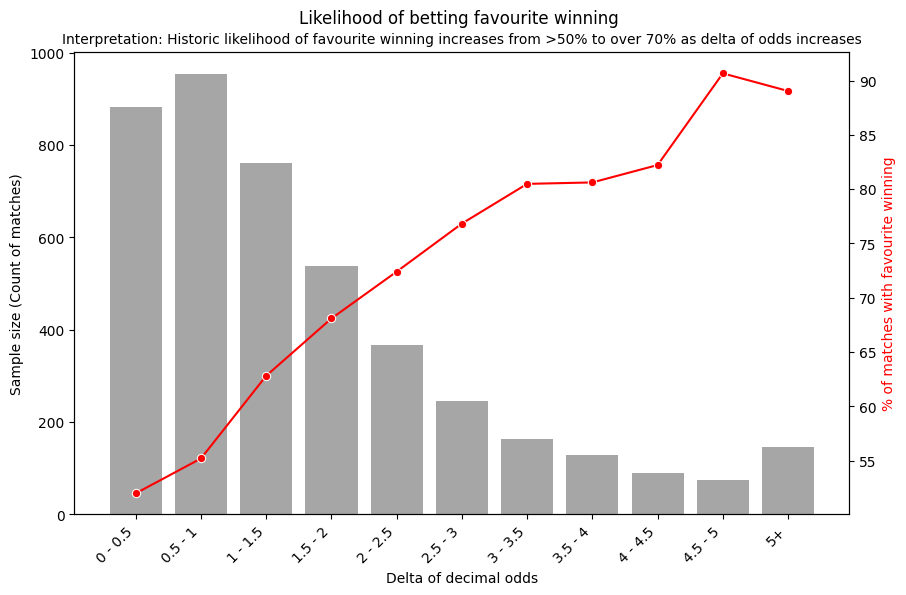

In [36]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(x=plot_df['delta_odds_bin'], y=plot_df['n'], alpha=0.7, ax=ax1, zorder=2, color="grey")
ax1.set_ylabel('Sample size (Count of matches)')
ax1.set_xlabel('Delta of decimal odds')
plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()

sns.lineplot(x=plot_df['delta_odds_bin'], y=plot_df['pct_fav_win'] * 100, marker='o', color="red", ax=ax2, zorder=3)
ax2.set_ylabel('% of matches with favourite winning', color="red")

plt.title("Likelihood of betting favourite winning \n")

info_text = "Interpretation: Historic likelihood of favourite winning increases from >50% to over 70% as delta of odds increases"
plt.text(0.5, 1.02, info_text, ha='center', fontsize=10, transform=ax1.transAxes)

plt.show()
